#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 09
**CH09A Estimating gender and age differences in earnings**

using the cps-earnings dataset

version 1.0 2021-05-05

In [26]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/cps-earnings/clean/"
data_out = dirname + "da_case_studies/ch09-gender-age-earnings/"
output = dirname + "da_case_studies/ch09-gender-age-earnings/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions
from py_helper_functions import *

In [4]:
data_all = pd.read_csv(data_in + "morg-2014-emp.csv")

In [5]:
# SELECT OCCUPATION
# keep only two occupation types: Market research analysts and marketing specialists
# and Computer and Mathematical Occupations
data_all.loc[data_all["occ2012"] == 735, "sample"] = 1
data_all.loc[
    ((data_all["occ2012"] >= 1005) & (data_all["occ2012"] <= 1240)), "sample"
] = 2
data_all.loc[data_all["sample"].isna(), "sample"] = 0

In [6]:
data_all = data_all.loc[
    (data_all["sample"] == 1) | (data_all["sample"] == 2), :
].reset_index(drop=True)

In [8]:
data_all["sample"].value_counts()

2.0    4740
1.0     281
Name: sample, dtype: int64

In [9]:
data_all["female"] = (data_all.sex == 2).astype(int)
data_all["w"] = data_all["earnwke"] / data_all["uhours"]
data_all["lnw"] = np.log(data_all["w"])
data_all["agesq"] = np.power(data_all["age"], 2)

In [10]:
i = 1
data = data_all.loc[data_all["sample"] == i, :].reset_index(drop=True)
data.to_csv(data_out + "earnings_inference.csv", index=False)

In [11]:
#####################
# DISTRIBUTION OF EARNINGS
#######################
data.loc[:, ["earnwke", "uhours", "w"]].describe()

,earnwke,uhours,w
count,281.000000,281.000000,281.000000
mean,1206.186940,40.153025,29.061656
std,709.545222,10.325838,14.712495
min,40.000000,5.000000,7.250000
25%,700.000000,40.000000,17.788250
50%,1096.150000,40.000000,25.950000
75%,1538.000000,40.000000,37.019000
max,2884.610000,80.000000,84.600000


In [12]:
data.loc[data.w >= 1, ["earnwke", "uhours", "w"]].describe()

,earnwke,uhours,w
count,281.000000,281.000000,281.000000
mean,1206.186940,40.153025,29.061656
std,709.545222,10.325838,14.712495
min,40.000000,5.000000,7.250000
25%,700.000000,40.000000,17.788250
50%,1096.150000,40.000000,25.950000
75%,1538.000000,40.000000,37.019000
max,2884.610000,80.000000,84.600000


In [13]:
data["female"].value_counts()

1    172
0    109
Name: female, dtype: int64

In [14]:
data.groupby(["occ2012", "female"]).size()

occ2012  female
735      0         109
         1         172
dtype: int64

In [15]:
##############################
# linear regressions
##############################

# First, look at them one by one

In [16]:
reg1 = smf.ols(formula="lnw~female", data=data).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.390
Date:                Mon, 03 May 2021   Prob (F-statistic):             0.0666
Time:                        20:57:19   Log-Likelihood:                -203.81
No. Observations:                 281   AIC:                             411.6
Df Residuals:                     279   BIC:                             418.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3149      0.048     69.004      0.000       3.220       3.409
female        -0.1131      0.061     -1.841      0.067      -0.234       0.008
==============================================================================
Omnibus:                        5.253   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                3.371
Skew:                          -0.070   Prob(JB):                        0.185
Kurtosis:                       2.482   Cond. No.                         2.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
reg2 = smf.ols(formula="lnw~female", data=data).fit(cov_type="HC1")
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.347
Date:                Mon, 03 May 2021   Prob (F-statistic):             0.0684
Time:                        20:57:21   Log-Likelihood:                -203.81
No. Observations:                 281   AIC:                             411.6
Df Residuals:                     279   BIC:                             418.9
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3149      0.049     67.810      0.000       3.219       3.411
female        -0.1131      0.062     -1.829      0.067      -0.234       0.008
==============================================================================
Omnibus:                        5.253   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                3.371
Skew:                          -0.070   Prob(JB):                        0.185
Kurtosis:                       2.482   Cond. No.                         2.97
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### Table 9.1 Wage and gender gap baseline regression

In [46]:
stargazer = Stargazer([reg1, reg2])
stargazer.covariate_order(["female","Intercept"])
stargazer.rename_covariates({"Intercept":"Constant"})
stargazer

In [18]:
reg3 = smf.ols(formula="lnw~age", data=data).fit(cov_type="HC1")
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     26.36
Date:                Mon, 03 May 2021   Prob (F-statistic):           5.31e-07
Time:                        20:57:23   Log-Likelihood:                -191.01
No. Observations:                 281   AIC:                             386.0
Df Residuals:                     279   BIC:                             393.3
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7317      0.101     27.006      0.000       2.533       2.930
age            0.0135      0.003      5.135      0.000       0.008       0.019
==============================================================================
Omnibus:                        1.782   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.410   Jarque-Bera (JB):                1.708
Skew:                          -0.109   Prob(JB):                        0.426
Kurtosis:                       2.687   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [19]:
reg4 = smf.ols(formula="lnw~age+agesq", data=data).fit(cov_type="HC1")
reg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     27.47
Date:                Mon, 03 May 2021   Prob (F-statistic):           1.29e-11
Time:                        20:57:23   Log-Likelihood:                -179.58
No. Observations:                 281   AIC:                             365.2
Df Residuals:                     278   BIC:                             376.1
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1935      0.341      3.499      0.000       0.525       1.862
age            0.0962      0.018      5.360      0.000       0.061       0.131
agesq         -0.0010      0.000     -4.608      0.000      -0.001      -0.001
==============================================================================
Omnibus:                        0.304   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.859   Jarque-Bera (JB):                0.353
Skew:                          -0.078   Prob(JB):                        0.838
Kurtosis:                       2.924   Cond. No.                     2.22e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 2.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
reg5 = smf.ols(formula="lnw~lspline(age,[30,40])", data=data).fit(cov_type="HC1")
reg5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     19.33
Date:                Mon, 03 May 2021   Prob (F-statistic):           2.07e-11
Time:                        20:57:27   Log-Likelihood:                -178.88
No. Observations:                 281   AIC:                             365.8
Df Residuals:                     277   BIC:                             380.3
Df Model:                           3                                         
Covariance Type:                  HC1                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.3834      0.369      3.753      0.000       0.661       2.106
lspline(age, [30, 40])[0]     0.0624      0.014      4.559      0.000       0.036       0.089
lspline(age, [30, 40])[1]     0.0165      0.010      1.680      0.093      -0.003       0.036
lspline(age, [30, 40])[2]    -0.0026      0.006     -0.444      0.657      -0.014       0.009
==============================================================================
Omnibus:                        0.184   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.912   Jarque-Bera (JB):                0.147
Skew:                          -0.056   Prob(JB):                        0.929
Kurtosis:                       2.991   Cond. No.                         410.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [21]:
reg6 = loess.KernelReg(data["lnw"], data["age"], var_type="c", reg_type="lc")
# loess.lowess(data['lnw'],data["age"],frac=0.75,return_sorted=False)
# reg6 = localr(y=data["lnw"], x=data["age"],kernel=gaussian,frac=0.75)

In [22]:
reg6

KernelReg instance
Number of variables: k_vars = 1
Number of samples:   N = 281
Variable types:      c
BW selection method: cv_ls
Estimator type: lc

### Table 9.2 Wage and age – different specifications

In [49]:
stargazer = Stargazer([reg3, reg4, reg5])
stargazer.covariate_order(
    [
        "age",
        "agesq",
        "lspline(age, [30, 40])[0]",
        "lspline(age, [30, 40])[1]",
        "lspline(age, [30, 40])[2]",
        "Intercept",
    ]
)
stargazer.rename_covariates(
    {
        "Intercept": "Constant",
        "agesq": "age squared",
        "lspline(age, [30, 40])[0]": "age spline <30",
        "lspline(age, [30, 40])[1]": "age spline 30–40",
        "lspline(age, [30, 40])[2]": "age spline 40<",
    }
)
stargazer

### Figure 9.3 Log hourly wage and age: regressions that capture nonlinearity

(a) Lowess regression and scatterplot

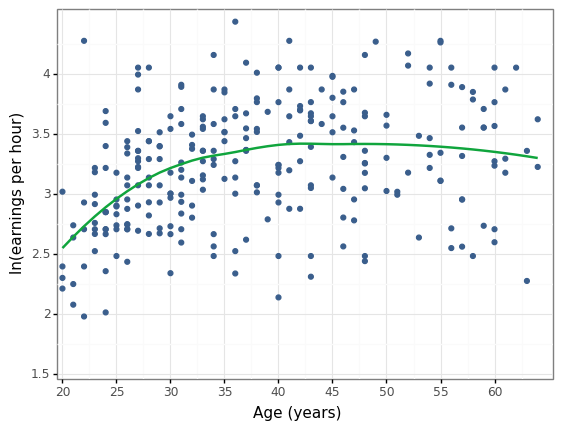

<ggplot: (328802039)>

In [39]:
##############################
# graphs
##############################
ggplot(data, aes(x="age", y="lnw")) + geom_point(color=color[0]) + geom_smooth(
    method="loess", color=color[1], se=False
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 65, by=5)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(1.5, 4.5), breaks=seq(1.5, 4.5, by=0.50)
) + labs(
    x="Age (years)", y="ln(earnings per hour)"
) + theme_bw()

In [30]:
z = reg4.get_prediction().conf_int()

In [31]:
res = reg4.get_prediction().summary_frame()
data["lnwpred_ageq"] = res["mean"]
data["lnwpred_ageqCIUP"] = [x[0] for x in z]
data["lnwpred_ageqCILO"] = [x[1] for x in z]

In [32]:
z = reg5.get_prediction().conf_int()

In [33]:
res = reg5.get_prediction().summary_frame()
data["lnwpred_agesp"] = res["mean"]
data["lnwpred_agespCIUP"] = [x[0] for x in z]
data["lnwpred_agespCILO"] = [x[1] for x in z]

In [34]:
data["lnwpred_agel"] = reg6.fit()[0]

(b) Lowess, piecewise linear spline, and quadratic

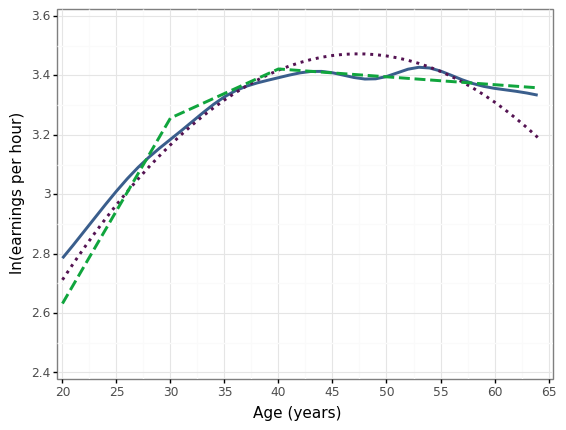

<ggplot: (328795655)>

In [42]:
ggplot(data, aes(x="age")) + geom_line(
    data,
    aes(y="lnwpred_agel"),
    color=color[0],
    linetype="solid",
    size=1.2,
    show_legend=True,
) + geom_line(
    data,
    aes(y="lnwpred_ageq"),
    color=color[2],
    linetype="dotted",
    size=1.2,
    show_legend=True,
) + geom_line(
    data,
    aes(y="lnwpred_agesp"),
    color=color[1],
    linetype="dashed",
    size=1.2,
    show_legend=True,
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 66, by=5)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(2.4, 3.6), breaks=seq(2.4, 3.6, by=0.20)
) + labs(
    x="Age (years)", y="ln(earnings per hour)"
) + theme_bw() + theme(
    legend_position=(45, 2.6),
    legend_direction="horizontal",
    legend_text=element_text(size=3),
    legend_key_width=0.8,
    legend_key_height=0.2,
) + guides(
    linetype=guide_legend(override_aes=dict(size=0.6))
) + scale_color_discrete(
    name=" ", values=["red", "cyan", "green"]
)

### Figure 9.4 Average log earnings and age: regressions with CI

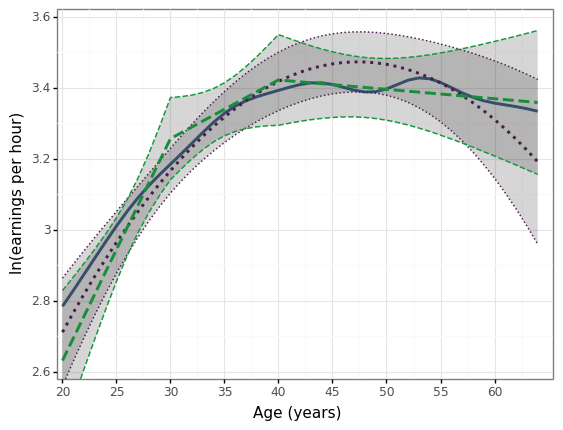

<ggplot: (321869352)>

In [39]:
ggplot(data, aes(x="age")) + geom_line(
    aes(y="lnwpred_agel"), color=color[0], linetype="solid", size=1.2
) + geom_line(
    aes(y="lnwpred_ageq"), color=color[2], linetype="dotted", size=1.2
) + geom_line(
    aes(y="lnwpred_ageqCIUP"), color=color[2], linetype="dotted", size=0.6
) + geom_line(
    aes(y="lnwpred_ageqCILO"), color=color[2], linetype="dotted", size=0.6
) + geom_ribbon(
    aes(ymin="lnwpred_ageqCILO", ymax="lnwpred_ageqCIUP"),
    alpha=0.2,
) + geom_line(
    aes(y="lnwpred_agesp"),
    color=color[1],
    linetype="dashed",
    size=1.2,
) + geom_line(
    aes(y="lnwpred_agespCIUP"),
    color=color[1],
    linetype="dashed",
    size=0.6,
) + geom_line(
    aes(y="lnwpred_agespCILO"),
    color=color[1],
    linetype="dashed",
    size=0.6,
) + geom_ribbon(
    aes(ymin="lnwpred_agespCILO", ymax="lnwpred_agespCIUP"), alpha=0.2
) + coord_cartesian(
    xlim=(20, 65), ylim=(2.6, 3.6)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 65, by=5)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(2.4, 3.6), breaks=seq(2.4, 3.6, by=0.20)
) + labs(
    x="Age (years)", y="ln(earnings per hour)"
) + scale_color_manual(
    name="", values=(color[1], color[2], color[3])
) + scale_linetype_manual(
    name="", values=("solid", "dashed", "dotted")
) + theme_bw() + theme(
    legend_position=(0.65, 0.1),
    legend_direction="horizontal",
    legend_text=element_text(size=4),
    legend_key_width=0.8,
    legend_key_height=0.2,
) + guides(
    linetype=guide_legend(override_aes=dict(size=0.6))
)

### Figure 9.2 Log hourly wage and age: regression line, confidence interval, prediction interval.

In [40]:
##########################################
# CI and PI for the linear model
##########################################
reg7 = smf.ols(
    formula="lnw~age",
    data=data.loc[
        data["sample"] == 1,
    ],
).fit()

(a) Confidence interval

In [41]:
pred_confidence = data.join(
    pd.DataFrame(reg7.get_prediction().conf_int(), columns=["lwr", "upr"])
).join(reg7.get_prediction().summary_frame()["mean"].rename("fit"))

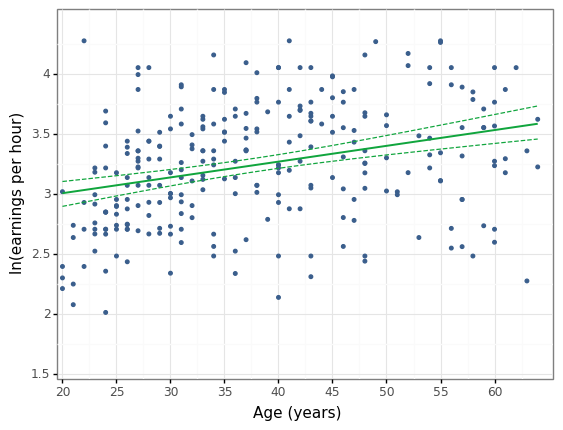

<ggplot: (328238635)>

In [42]:
ggplot(
    pred_confidence.loc[lambda x: (x["lnw"] < 4.4) & (x["lnw"] > 2)],
    aes(x="age", y="lnw"),
) + geom_point(
    color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True
) + geom_smooth(
    method="lm", colour=color[1], se=False, size=0.8, linetype="solid"
) + geom_line(
    pred_confidence, aes(x="age", y="lwr"), size=0.5, linetype="dashed", colour=color[1]
) + geom_line(
    pred_confidence, aes(x="age", y="upr"), size=0.5, linetype="dashed", colour=color[1]
) + coord_cartesian(
    xlim=(20, 65), ylim=(1.5, 4.5)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 65, by=5)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(1.5, 4.5), breaks=seq(1.5, 4.5, by=0.50)
) + labs(
    x="Age (years)", y="ln(earnings per hour)"
) + scale_linetype_manual(
    name="",
    values=(1, 1, 2),
    labels=("Lowess", "Confidence interval (95%)", "Confidence interval (95%)"),
) + theme_bw()

(b) Prediction interval

In [43]:
pred_interval = data
pred_interval[["lwr", "upr"]] = (
    reg7.get_prediction().summary_frame().loc[:, ["obs_ci_lower", "obs_ci_upper"]]
)
pred_interval = pred_interval.join(
    reg7.get_prediction().summary_frame()["mean"].rename("fit")
)

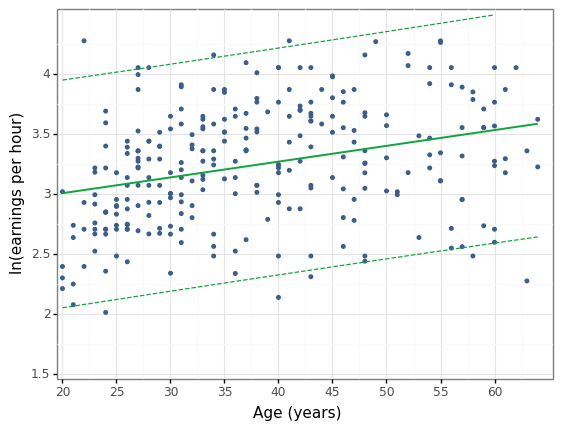

<ggplot: (328280447)>

In [44]:
ggplot(
    pred_interval.loc[lambda x: (x["lnw"] < 4.4) & (x["lnw"] > 2)],
    aes(x="age", y="lnw"),
) + geom_point(
    color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True
) + geom_smooth(
    method="lm", colour=color[1], se=False, size=0.8, linetype="solid"
) + geom_line(
    pred_interval, aes(y="lwr"), size=0.5, linetype="dashed", colour=color[1]
) + geom_line(
    pred_interval, aes(y="upr"), size=0.5, linetype="dashed", colour=color[1]
) + coord_cartesian(
    xlim=(20, 65), ylim=(1.5, 4.5)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 65, by=5)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(1.5, 4.5), breaks=seq(1.5, 4.5, by=0.50)
) + labs(
    x="Age (years)", y="ln(earnings per hour)"
) + theme_bw()

### Figure 9.1 Bootstrap distribution of the average female–male wage difference among market analysts

In [45]:
data = pd.read_csv(data_out + "earnings_inference.csv")

In [46]:
def bs_linreg(x, y, size=1, seed=200999):
    """Perform pairs bootstrap for linear regression."""
    # Set up array of indices to sample from
    inds = np.arange(len(x))

    # Initialize samples
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    np.random.seed(seed)
    # Take samples
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds), replace=True)
        bs_x, bs_y = sm.add_constant(x[bs_inds]), y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = (
            sm.regression.linear_model.OLS(bs_y, bs_x).fit().params
        )

    return bs_slope_reps, bs_intercept_reps

In [47]:
results = bs_linreg(data.lnw.values, data.female.values, size=1000)

b_earnings_female = pd.DataFrame(results).T

b_earnings_female.columns = ["_b_intercept", "_b_female"]

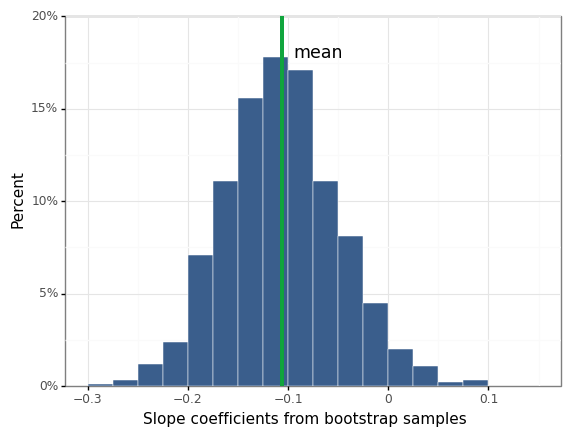

<ggplot: (321859657)>

In [48]:
ggplot(b_earnings_female, aes(x="_b_female")) + geom_histogram(
    aes(y="stat(count)/sum(stat(count))"),
    binwidth=0.025,
    center=0.0125,
    closed="left",
    color="white",
    fill=color[0],
    size=0.2,
    alpha=0.8,
    show_legend=False,
    na_rm=True,
) + geom_segment(
    aes(
        x=b_earnings_female["_b_female"].mean(),
        y=0,
        xend=b_earnings_female["_b_female"].mean(),
        yend=0.2,
    ),
    colour=color[1],
    size=1,
) + annotate(
    "text", x=-0.07, y=0.18, label="mean", size=12.5
) + coord_cartesian(
    xlim=(-0.3, 0.15), ylim=(0, 0.2)
) + labs(
    x="Slope coefficients from bootstrap samples", y="Percent"
) + scale_y_continuous(
    expand=(0.0, 0.0), limits=(0, 0.2), labels=percent_format()
) + theme_bw()